In [1]:
import pandas as pd
df = pd.read_csv(r'E:\elevatetrsest\crop price predictor\Crop_price_Prediction\data\edited_21_24.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27676 entries, 0 to 27675
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       27676 non-null  int64  
 1   avg_modal_price  27676 non-null  float64
 2   avg_min_price    27676 non-null  float64
 3   avg_max_price    27676 non-null  float64
 4   month            27676 non-null  int64  
 5   year             27676 non-null  int64  
 6   date             27676 non-null  int64  
 7   district_name    27676 non-null  int64  
 8   commodity_name   27676 non-null  int64  
 9   state_name       27676 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 2.1 MB


In [4]:
df['datetime'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.date))

In [ ]:
# Example for avg_modal_price
df_modal = df[['datetime', 'avg_modal_price']].rename(columns={'datetime': 'ds', 'avg_modal_price': 'y'})

# Repeat for avg_min_price and avg_max_price
df_min = df[['datetime', 'avg_min_price']].rename(columns={'datetime': 'ds', 'avg_min_price': 'y'})
df_max = df[['datetime', 'avg_max_price']].rename(columns={'datetime': 'ds', 'avg_max_price': 'y'})

In [6]:
from prophet import Prophet

# Model for avg_modal_price
model_modal = Prophet()
model_modal.fit(df_modal)

# Model for avg_min_price
model_min = Prophet()
model_min.fit(df_min)

# Model for avg_max_price
model_max = Prophet()
model_max.fit(df_max)


C:\Users\Shiva\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1] done processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing
15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Create future DataFrame (e.g., next 30 days)
future_modal = model_modal.make_future_dataframe(periods=30)
future_min = model_min.make_future_dataframe(periods=30)
future_max = model_max.make_future_dataframe(periods=30)

# Make predictions
forecast_modal = model_modal.predict(future_modal)
forecast_min = model_min.predict(future_min)
forecast_max = model_max.predict(future_max)


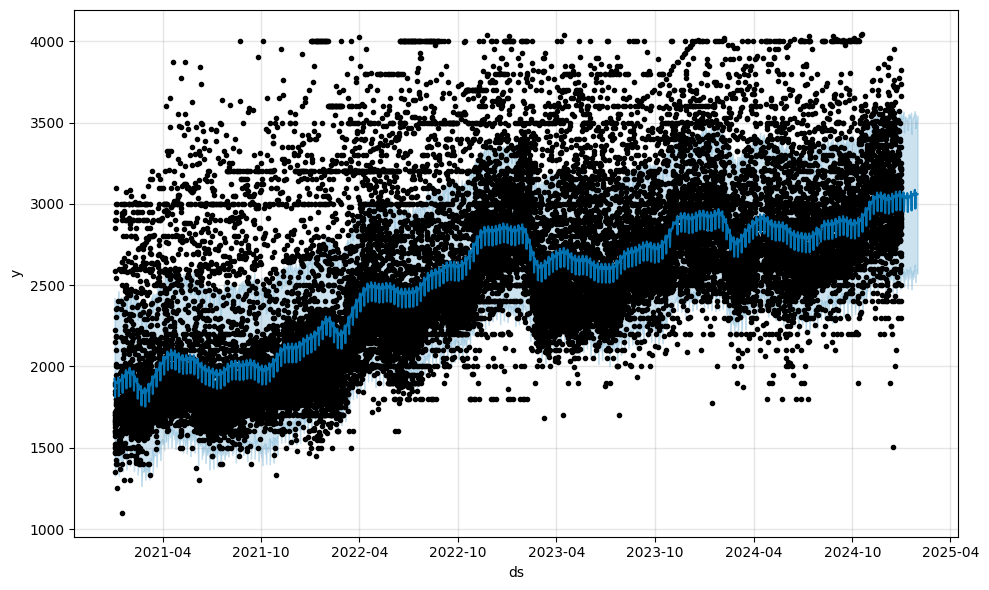

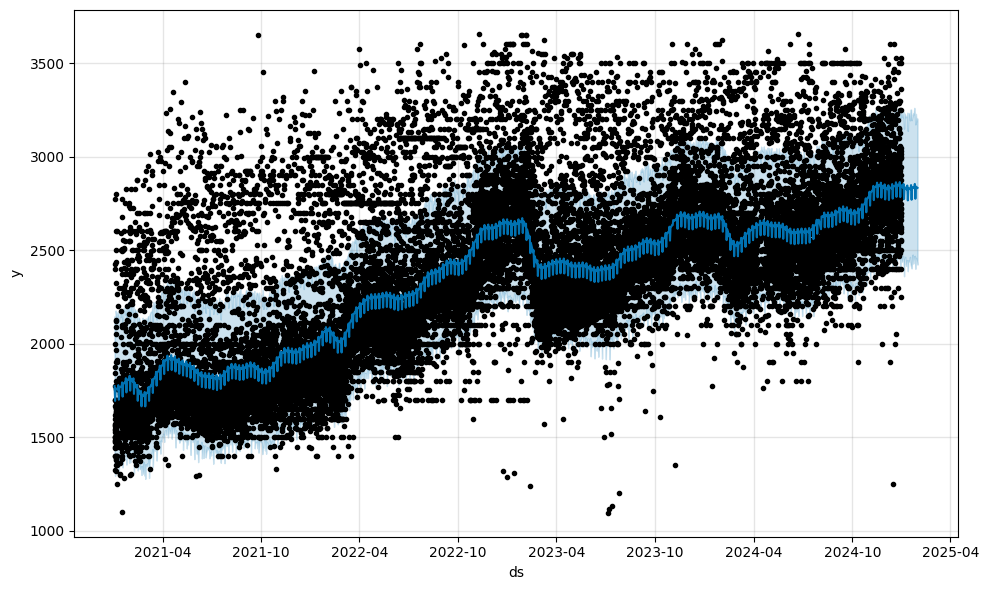

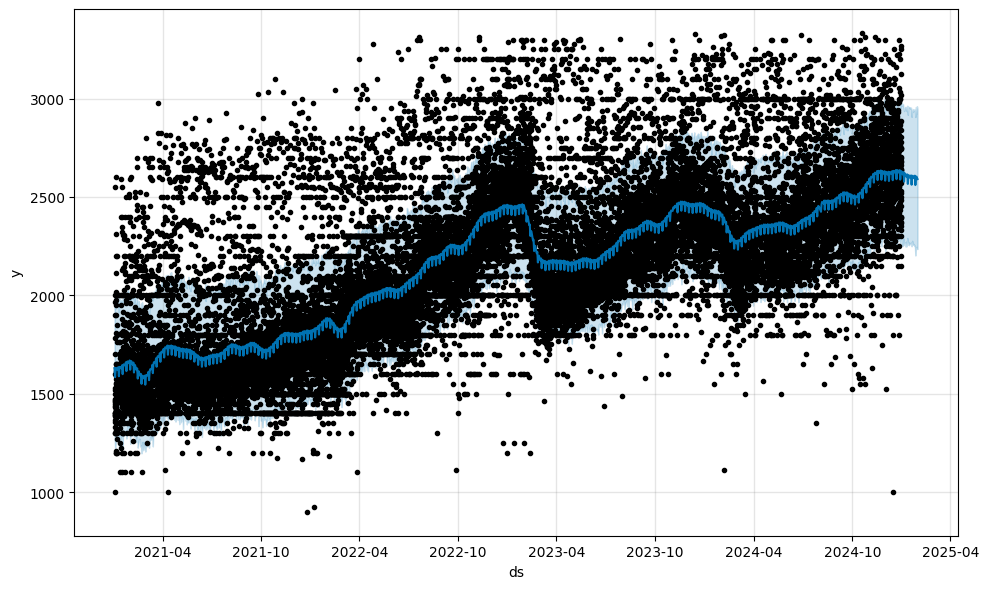

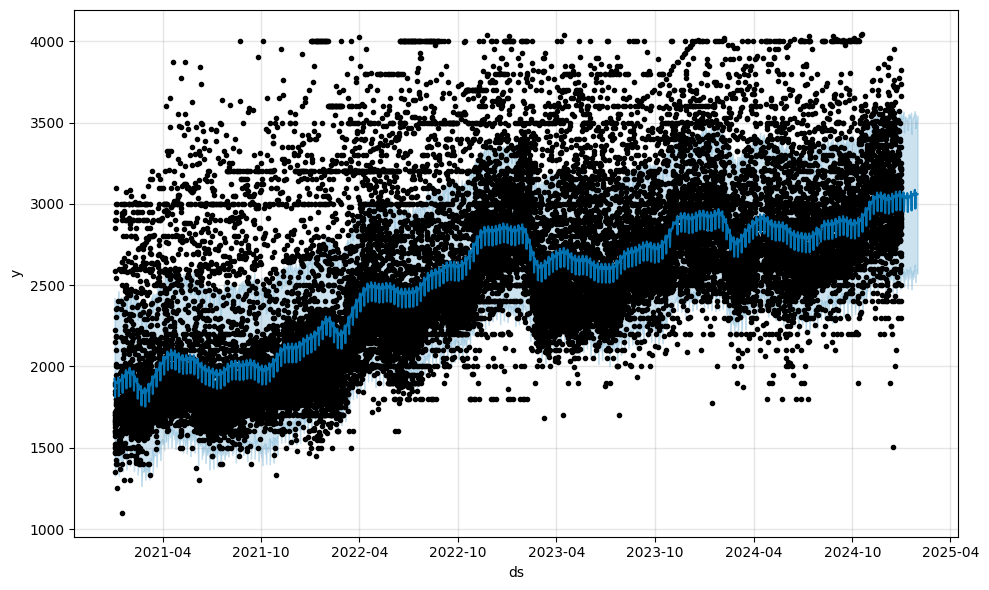

In [9]:
# Plot for avg_modal_price
model_modal.plot(forecast_modal)

# Plot for avg_min_price
model_min.plot(forecast_min)

# Plot for avg_max_price
model_max.plot(forecast_max)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example for avg_modal_price
mae_modal = mean_absolute_error(df_modal['y'], forecast_modal['yhat'][:len(df_modal)])
mse_modal = mean_squared_error(df_modal['y'], forecast_modal['yhat'][:len(df_modal)])
r2_modal = r2_score(df_modal['y'], forecast_modal['yhat'][:len(df_modal)])


In [14]:
# Load test dataset for 2025
test_data = pd.read_csv(r"E:\elevatetrsest\crop price predictor\Crop_price_Prediction\data\test_edited_25.csv")
test_data['ds'] = pd.to_datetime(dict(year=test_data.year, month=test_data.month, day=test_data.date))

test_data['ds'] = pd.to_datetime(test_data['ds'])  # Ensure 'ds' is in datetime format


In [17]:
# Load the trained Prophet model (assume it's ready)
model_modal = Prophet()
model_modal.fit(df_modal)



15:55:05 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create future DataFrame for 90 points
future = model_modal.make_future_dataframe(periods=90)


In [24]:
# Predict future values
forecast = model_modal.predict(future)

# Filter predictions for the test dates (2025)
forecast_2025 = forecast[forecast['ds'].isin(test_data['ds'])]

test_data.rename(columns={ 'avg_modal_price': 'y'} , inplace=True)



In [25]:
# Combine actual and predicted values
comparison = test_data[['ds', 'y']].merge(forecast_2025[['ds', 'yhat']], on='ds')


In [28]:
comparison.head()

,ds,y,yhat
0,2025-03-12,3500.0,2718.328552
1,2025-03-11,3420.0,2714.555191
2,2025-03-05,2810.0,2692.615918
3,2025-03-04,2900.0,2690.228268
4,2025-02-28,3440.0,2678.659074


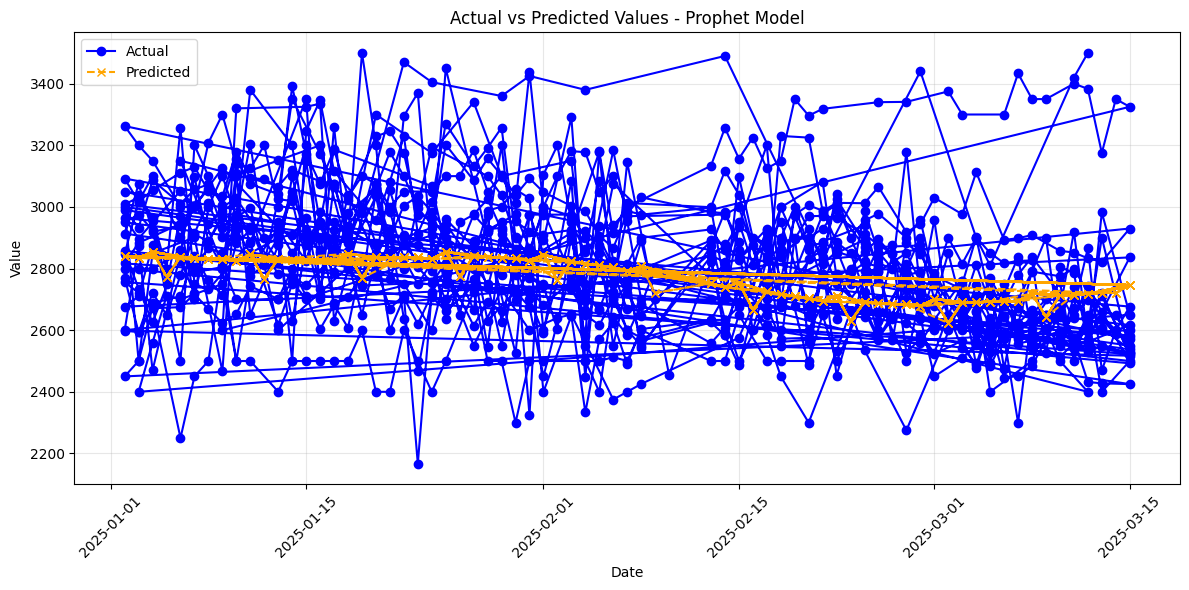

In [27]:
# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual', marker='o', color='blue')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', marker='x', color='orange', linestyle='--')
plt.title("Actual vs Predicted Values - Prophet Model")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
